# spike counts visualization

This tutorial demonstrates the way of visualizing the spike counts of the last SNN layer.

In [2]:
! pip install matplotlib

In [3]:
import torch
import samna
import time
import random
import copy
import matplotlib.pyplot as plt

from torch import nn
from sinabs.backend.dynapcnn import DynapcnnNetwork
from multiprocessing import Process
from sinabs.from_torch import from_model
from sinabs.layers.pool2d import SumPool2d
from typing import Union

## Create a 1-layer CNN which can be deployed to the devkit

In [4]:
# init a cnn it has 2 out_channels for a binary classification task
# the input shape of this cnn is (1, 16, 16), output shape of this cnn is (2, 1, 1)

input_shape = (1, 16, 16)

cnn = nn.Sequential(SumPool2d(kernel_size=(1, 1)),
                    nn.Conv2d(in_channels=1,
                              out_channels=2,
                              kernel_size=(16, 16),
                              stride=(1, 1),
                              padding=(0, 0),
                              bias=False),
                    nn.ReLU())

**assign the CNN layer with a handcraft weight**:

The reason for designing the weights in this way is:

1. We will create a bunch of fake input spikes $X[x_0, x_1, ...x_{T}]$ as the input of the devkit.
2. for any input spike $x_{t}$ with timestamp $t$:

- if $t$, if $t < 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [0, 7], i.e. on the top-half of the input region.
- if $t$, if $t > 0.5 * T$, the $y$ coordinate of spike $x_t$ will be in range [8, 15].i.e. on the bottom-half of the input region.

3. Based on this
- the output spike from time $0$ to $0.5 * T$ will all come from output channel #0
- the output spike from time $0.5 * T$ to $T$ will all come from output channel #1

![handcraft_weights](../_static/using_readout_layer/handcraft_weights.png)

In [5]:
# set handcraft weights for the CNN
weight_ones = torch.ones(1, 8, 16, dtype=torch.float32)
weight_zeros = torch.zeros(1, 8, 16, dtype=torch.float32)

channel_1_weight = torch.cat([weight_ones, weight_zeros], dim=1).unsqueeze(0)
channel_2_weight = torch.cat([weight_zeros, weight_ones], dim=1).unsqueeze(0)
handcraft_weight = torch.cat([channel_1_weight, channel_2_weight], dim=0)

output_cnn_lyr_id = 1
cnn[output_cnn_lyr_id].weight.data = handcraft_weight

Then we convert the CNN into SNN and trying to deploy it to the devkit

In [6]:
# cnn to snn
snn = from_model(cnn, input_shape=input_shape, batch_size=1).spiking_model
# snn to DynapcnnNetwork
dynapcnn_net = DynapcnnNetwork(snn=snn, input_shape=input_shape, dvs_input=False)

## Define an auxiliary class for devkit configuration and samna graph construction

Samna graph defines how the data flows into and out from the devkit:

![samna graph](../_static/using_readout_layer/samna_graph.png)

This class takes a DynapcnnNetwork object as init input. And it will generate the proper devkit config and samna graph for the deployment.

Then by calling the `run` method of this class we can:

1. visualize the input from a GUI window
2. visualize the spike counts of the last DynapCNN layer with line chart.

### Notice

**Make sure your devkit is plugged in your PC when running the experiment codes below**

In [7]:
class DevkitAssistant:

    def __init__(
            self,
            dynapcnn_net: DynapcnnNetwork,
            labels: list,
            time_interval: int = 50,
            ):

        """
        Args:
            dynapcnn_net: a DynapcnnNetwork object
            labels: a list that contains the names of output channels
            time_interval: time interval for counting spikes. the unit is milisecond.

        """

        # some basic attributes for showing spike counts
        self.labels = labels
        self.num_of_classes = len(labels)
        self.time_interval = time_interval

        # generate configuration object for devkit
        self.dynapcnn_net: DynapcnnNetwork = copy.deepcopy(dynapcnn_net)
        self.devkit_cfg = self.dynapcnn_net.make_config(device="speck2edevkit:0")

        # open the Speck2eDevKit and get the devkit handle
        self.devkit = samna.device.open_device("Speck2eDevKit:0")

        # get io module of the devkit
        self.dk_io = self.devkit.get_io_module()

        # init samna node for tcp transmission
        samna_node = samna.init_samna()
        self.sender_endpoint = samna_node.get_sender_endpoint()
        self.receiver_endpoint = samna_node.get_receiver_endpoint()
        self.streamer_endpoint = 'tcp://0.0.0.0:40008'  # this port is for dvs input data visualization
        self.visualizer_id = 3
        time.sleep(1)  # wait tcp connection build up, this is necessary to open remote node.

        # build the samna graph
        self.samna_graph, *buffer_nodes = self.build_samna_graph()
        self.input_buffer, self.spike_buffer = buffer_nodes

        # create & set up the visualizer
        self.visualizer, self.gui_process = self.open_visualizer()
        self.setup_visualizer()

        # start graph
        self.samna_graph.start()

    def run(self, input_events: list, read_pin_value: bool):

        """
        This function contains the main logic of using the readout layer:
        1. reset devkits' stop-watch
        2. write fake inputs into hardware
        3. get output from both readout layer and cnn layer

        Args:
            input_events: a list contains the input
            read_pin_value: choose to read ReadoutPinValue or ReadoutValue from readout layer
        """
        # modify samna config
        self.modify_devkit_cfg(read_pin_value=read_pin_value)
        # apply devkit config to hardware
        self.devkit.get_model().apply_configuration(self.devkit_cfg)
        time.sleep(0.1)

        # reset the stop-watch of devkit
        stop_watch = self.devkit.get_stop_watch()
        stop_watch.set_enable_value(True)
        stop_watch.reset()
        time.sleep(0.01)

        # clear buffer
        self.spike_buffer.get_events()

        # write the input to devkit
        input_time_length = (input_events[-1].timestamp - input_events[0].timestamp) / 1e6
        self.input_buffer.write(input_events)
        # sleep till all input events is sent and processed
        time.sleep(input_time_length + 0.02)

        # get spikes from cnn layer
        spikes = self.spike_buffer.get_events()

        # return the output from readout layer and cnn layer both
        return spikes

    def modify_devkit_cfg(self, read_pin_value: bool):

        """
        since we need to use the readout layer of Speck2e devkit. Some modifications need to be implemented
        on the devkits' configuration

        """

        """cnn layers configuration"""
        # send to output spike from cnn output layer to readout layer as its input
        cnn_output_layer = self.dynapcnn_net.chip_layers_ordering[-1]
        # the readout layer id is fixed for speck2e devkit which is 12
        readout_layer = 12
        print(f'link output layer: {cnn_output_layer} to readout layer: {readout_layer}')
        self.devkit_cfg.cnn_layers[cnn_output_layer].monitor_enable = True
        self.devkit_cfg.cnn_layers[cnn_output_layer].destinations[0].enable = True
        self.devkit_cfg.cnn_layers[cnn_output_layer].destinations[0].layer = readout_layer

        """dvs layer configuration"""
        # link the dvs layer to the 1st layer of the cnn layers
        self.devkit_cfg.dvs_layer.destinations[0].enable = True
        self.devkit_cfg.dvs_layer.destinations[0].layer = self.dynapcnn_net.chip_layers_ordering[0]
        # merge the polarity of input events
        self.devkit_cfg.dvs_layer.merge = True
        # drop the raw input events from the dvs sensor, since we write events to devkit manually
        self.devkit_cfg.dvs_layer.pass_sensor_events = False
        # enable monitoring the output from dvs pre-preprocessing layer
        self.devkit_cfg.dvs_layer.monitor_enable = True

        return

    def build_samna_graph(self):

        """
        samna graph defines how data the data read from the devkit flows.

        """

        # init the graph
        graph = samna.graph.EventFilterGraph()
        # init necessary nodes
        input_buffer_node = samna.BasicSourceNode_speck2e_event_speck2e_input_event()
        spike_buffer_node = samna.BasicSinkNode_speck2e_event_output_event()

        # build input branch for graph
        graph.sequential([input_buffer_node, self.devkit.get_model_sink_node()])

        # build output branches for graph
        # branch #1: for the dvs input visualization
        _, _, streamer = graph.sequential(
            [self.devkit.get_model_source_node(), "Speck2eDvsToVizConverter", "VizEventStreamer"])
        # branch #2: for the spike count plot (first divide spike events into groups, then cout spike events grouping by feature.)
        _, spike_collection_filter, spike_count_filter, _ = graph.sequential(
            [self.devkit.get_model_source_node(), "Speck2eSpikeCollectionNode", "Speck2eSpikeCountNode", streamer])
        # branch #3: for obtaining the output Spike from cnn output layer
        _, type_filter_node_spike, _ = graph.sequential(
            [self.devkit.get_model_source_node(), "Speck2eOutputEventTypeFilter", spike_buffer_node])

        # set the filter nodes of the graph
        streamer.set_streamer_endpoint(self.streamer_endpoint)
        spike_collection_filter.set_interval_milli_sec(self.time_interval)  # divide according to this time period in milliseconds.
        spike_count_filter.set_feature_count(self.num_of_classes)  # number of output classes
        type_filter_node_spike.set_desired_type("speck2e::event::Spike")

        return graph, input_buffer_node, spike_buffer_node

    def run_visualizer_process(self, receiver_endpoint, sender_endpoint):

        import samnagui
        samnagui.runVisualizer(0.6, 0.6, receiver_endpoint, sender_endpoint, self.visualizer_id)

        return

    def open_visualizer(self):

        """
        create a sub-process for running the visualizer window

        """

        gui_process = Process(target=self.run_visualizer_process, args=(self.receiver_endpoint, self.sender_endpoint))
        gui_process.start()

        # wait for open visualizer and connect to it.
        timeout = 10
        begin = time.time()
        name = "visualizer" + str(self.visualizer_id)
        while time.time() - begin < timeout:

            try:

                time.sleep(0.05)
                samna.open_remote_node(self.visualizer_id, name)

            except:

                continue

            else:

                visualizer = getattr(samna, name)

                return visualizer, gui_process

        raise Exception("open_remote_node failed:"
                        "  visualizer id %d can't be opened in %d seconds!!" % (self.visualizer_id, timeout))

    def setup_visualizer(self):

        """
        set the visualizer and related GUI

        """

        # set visualizer's receiver endpoint to streamer's sender endpoint
        self.visualizer.receiver.set_receiver_endpoint(self.streamer_endpoint)
        # connect the receiver output to splitter inside the visualizer
        self.visualizer.receiver.add_destination(self.visualizer.splitter.get_input_channel())

        # add DVS plot to gui
        activity_plot_id = self.visualizer.plots.add_activity_plot(128, 128, "DVS Layer")
        plot = self.visualizer.plot_0
        plot.set_layout(0, 0, 0.5, 1.0)

        # add plot to show spike counts
        spike_count_id = self.visualizer.plots.add_spike_count_plot("Spike Count", self.num_of_classes, self.labels)
        plot = self.visualizer.plot_1
        plot.set_layout(0.5, 0.5, 1, 1)
        plot.set_show_x_span(10)  # set the range of x axis
        plot.set_label_interval(1.0)  # set the x axis label interval
        plot.set_max_y_rate(1.2)  # set the y axis max value according to the max value of all actual values. 
        plot.set_show_point_circle(True)  # if show a circle of every point.
        plot.set_default_y_max(10)  # set the default y axis max value when all points value is zero.

        self.visualizer.splitter.add_destination("dvs_event", self.visualizer.plots.get_plot_input(activity_plot_id))
        self.visualizer.splitter.add_destination("spike_count", self.visualizer.plots.get_plot_input(spike_count_id))
        self.visualizer.plots.report()

        return


## Create fake input for devkit

In [8]:
def create_fake_input_events(time_sec: int, data_rate: int = 1000):

    """
    Args:
        time_sec: how long is the input events
        data_rate: how many input events generated in 1 second

        During the first half time, it generates events where y coordinate only in range[0, 7] which means top half
        region of the input feature map.

        Then in the last half of time, it generates events where y coordinate only in range[8, 15] which means bottom
        half region of the input feature map.

    """

    time_offset_micro_sec = 5000  # make the timestamp start from 5000
    time_micro_sec = time_sec * 1000000  # timestamp unit is micro-second
    time_stride = 1000000 // data_rate

    half_time = time_micro_sec // 2

    events = []
    for time_stamp in range(time_offset_micro_sec, time_micro_sec + time_offset_micro_sec + 1, time_stride):

        spk = samna.speck2e.event.DvsEvent()
        spk.timestamp = time_stamp
        spk.p = random.randint(0, 1)
        spk.x = random.randint(0, 15)

        if time_stamp < half_time:
            spk.y = random.randint(0, 7)  # spike located in top half of the input region
        else:
            spk.y = random.randint(8, 15)  # spike located in bottom half of the input region

        events.append(spk)

    return events

In [9]:
# create fake input events
input_time_length = 5 # seconds
data_rate = 5000
input_events = create_fake_input_events(time_sec=input_time_length, data_rate=data_rate)

print(f"number of fake input spikes: {len(input_events)}")

number of fake input spikes: 25001


In [10]:
# init the devkit assistant

# we create 2 assistant:
#one for read the ReadoutPinValue of the devkit
readout_threshold = 1
slow_clk_freq = 20 # Hz

# estimated slow-clock cycle for processing the input spikes
clock_cycles_esitmated = slow_clk_freq * input_time_length

# by init the devkit assistant, it also opens the devkit, visualization GUI window
devkit_assistant = DevkitAssistant(dynapcnn_net,
                                   labels=["0", "1"])

Network is valid
sender_endpoint: tcp://0.0.0.0:46091
receiver_endpoint: tcp://0.0.0.0:42599


### start visualizing

In [13]:
dynapcnn_layer_events = devkit_assistant.run(input_events, read_pin_value=True)

link output layer: 0 to readout layer: 12


### check the output from DynapCNN Layer

number of output spikes from DynacpCNN Layer: 25001


Text(0.5, 1.0, 'Spike')

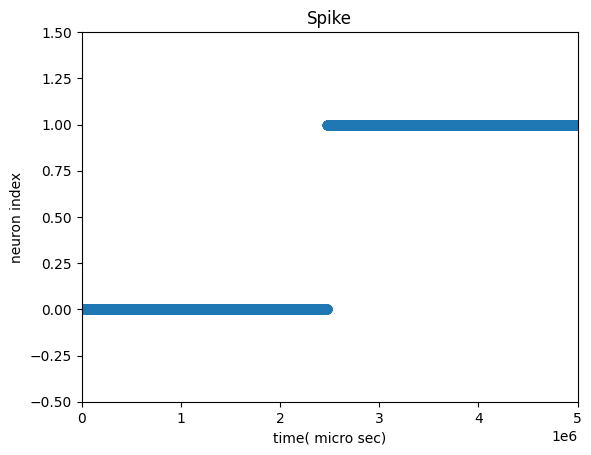

In [14]:
print(f"number of output spikes from DynacpCNN Layer: {len(dynapcnn_layer_events)}")

# get the timestamp of the output event
spike_timestamp = [each.timestamp for each in dynapcnn_layer_events]
# shift timestep starting from 0
start_t = spike_timestamp[0]
spike_timestamp = [each - start_t for each in spike_timestamp]

# get the neuron index of each output spike 
neuron_id = [each.feature  for each in dynapcnn_layer_events]


# plot the output neuron index vs. time
fig, ax = plt.subplots()
ax.scatter(spike_timestamp, neuron_id)
ax.set(xlim=(0, 5e6),ylim=(-0.5, 1.5))
ax.set_xlabel("time( micro sec)")
ax.set_ylabel("neuron index")
ax.set_title("Spike")

# we should see the neuron index are 0 and 4, because of the incorrect map relationship on speck2e devkit

In [1]:
devkit_assistant.samna_graph.stop()
samna.device.close_device(devkit_assistant.devkit)

NameError: name 'devkit_assistant' is not defined